## Занятие 7: Докинг низкомолекулярных лигандов в структуру белка

### Лев Мазаев, мАДБМ18

### Загрузка модулей

In [1]:
import numpy as np

# Loading Open Drug Discovery Toolkit
import oddt
import oddt.docking
import oddt.interactions

# Structures import and visualization
from Bio.PDB import *
from ipywidgets import VBox, HBox
import IPython.display as ipd
import nglview as nv

# Working with SMILES
from rdkit import Chem

# Working with tables
import pandas as pd

RDKit WARNING: [23:51:15] Enabling RDKit 2019.09.2 jupyter extensions


_ColormakerRegistry()

### Разделение белка и лиганда

Визуализируем структуру белка с лигандом:

In [2]:
view1 = nv.show_structure_file('lys_pig_ligand.B99990002.pdb')
view1._remote_call('setSize', target='Widget', args=['640px', '480px'])
view1.representations = [
    {"type": "cartoon", "params": {"sele": "protein", "color": "residueindex"}},
    {"type": "ball+stick", "params": {"sele": "ligand"}}
]
view1

NGLWidget()

Загрузим структуру и посмотрим остатки:

In [3]:
parser = PDBParser()
pdb = parser.get_structure('lys_pig_ligand', 'lys_pig_ligand.B99990002.pdb')

for res in pdb.get_residues():
    if res.id[1] > 140:
        print(res)

<Residue ILE het=  resseq=141 icode= >
<Residue ARG het=  resseq=142 icode= >
<Residue GLY het=  resseq=143 icode= >
<Residue CYS het=  resseq=144 icode= >
<Residue LYS het=  resseq=145 icode= >
<Residue LEU het=  resseq=146 icode= >
<Residue NAG het=H_NAG resseq=147 icode= >
<Residue NAG het=H_NAG resseq=148 icode= >
<Residue NDG het=H_NDG resseq=149 icode= >


147-149 остатки в структуре - лиганд. Создадим отдельные объекты белка и лиганда:

In [4]:
class NonHetSelect(Select):
    
    def accept_residue(self, residue):
        return 1 if residue.id[0] == ' ' else 0
    
class HetSelect(Select):
    
    def accept_residue(self, residue):
        return 0 if residue.id[0] == ' ' else 1
    
io = PDBIO()
io.set_structure(pdb)
io.save('protein.pdb', NonHetSelect())
io.save('ligand.pdb', HetSelect())

Найдем геометрический центр лиганда:

In [5]:
ligand = parser.get_structure('ligand', 'ligand.pdb')
atom_coords = []

for atom in ligand.get_atoms():
    v = atom.get_vector()
    atom_coords.append(v.get_array())
    
geom_center = np.mean(atom_coords, axis=0)
print(geom_center)

[46.8601162  32.48079069 31.7858138 ]


### Подготовка белка для докинга

In [6]:
protein = next(oddt.toolkit.readfile('pdb', 'protein.pdb'))
protein.OBMol.AddPolarHydrogens()
protein.OBMol.AutomaticPartialCharge()

True

In [7]:
print(f'Is it protein? {protein.protein}')
print(f'Molecular weight: {round(protein.molwt, 3)}')
protein.protein = True  # исправим

Is it protein? False
Molecular weight: 16475.905


### Лиганды для докинга

Отобразим исходный лиганд в двухмерном виде:

NAG NAG NDG


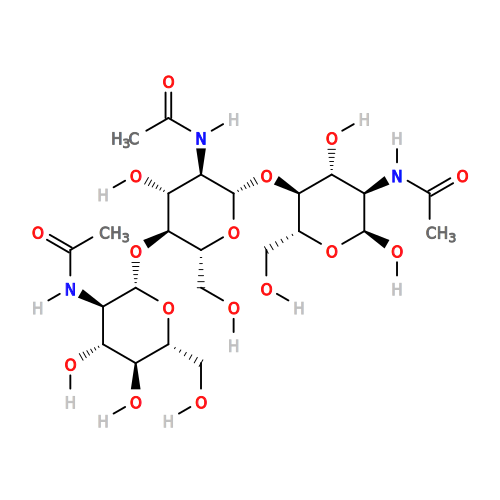

In [8]:
ligand = next(oddt.toolkit.readfile('pdb', 'ligand.pdb'))
ligand.OBMol.AddPolarHydrogens()
ligand.OBMol.AutomaticPartialCharge()
print(*(r.name for r in ligand.residues))
ipd.SVG(ligand.write('svg', opt={'d': None, 'P': 500}))

Будем проводить докинг исключительно NAG-лиганда, т. е. одной из составляющих исходного, меняя метильную группу на предложенные радикалы. Как он выглядит?

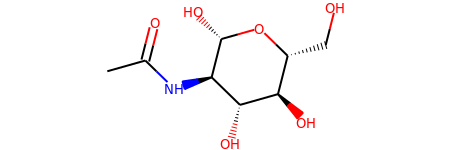

In [9]:
Chem.MolFromSmiles('CC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O')

Посмотрим на NAG с заместителями:

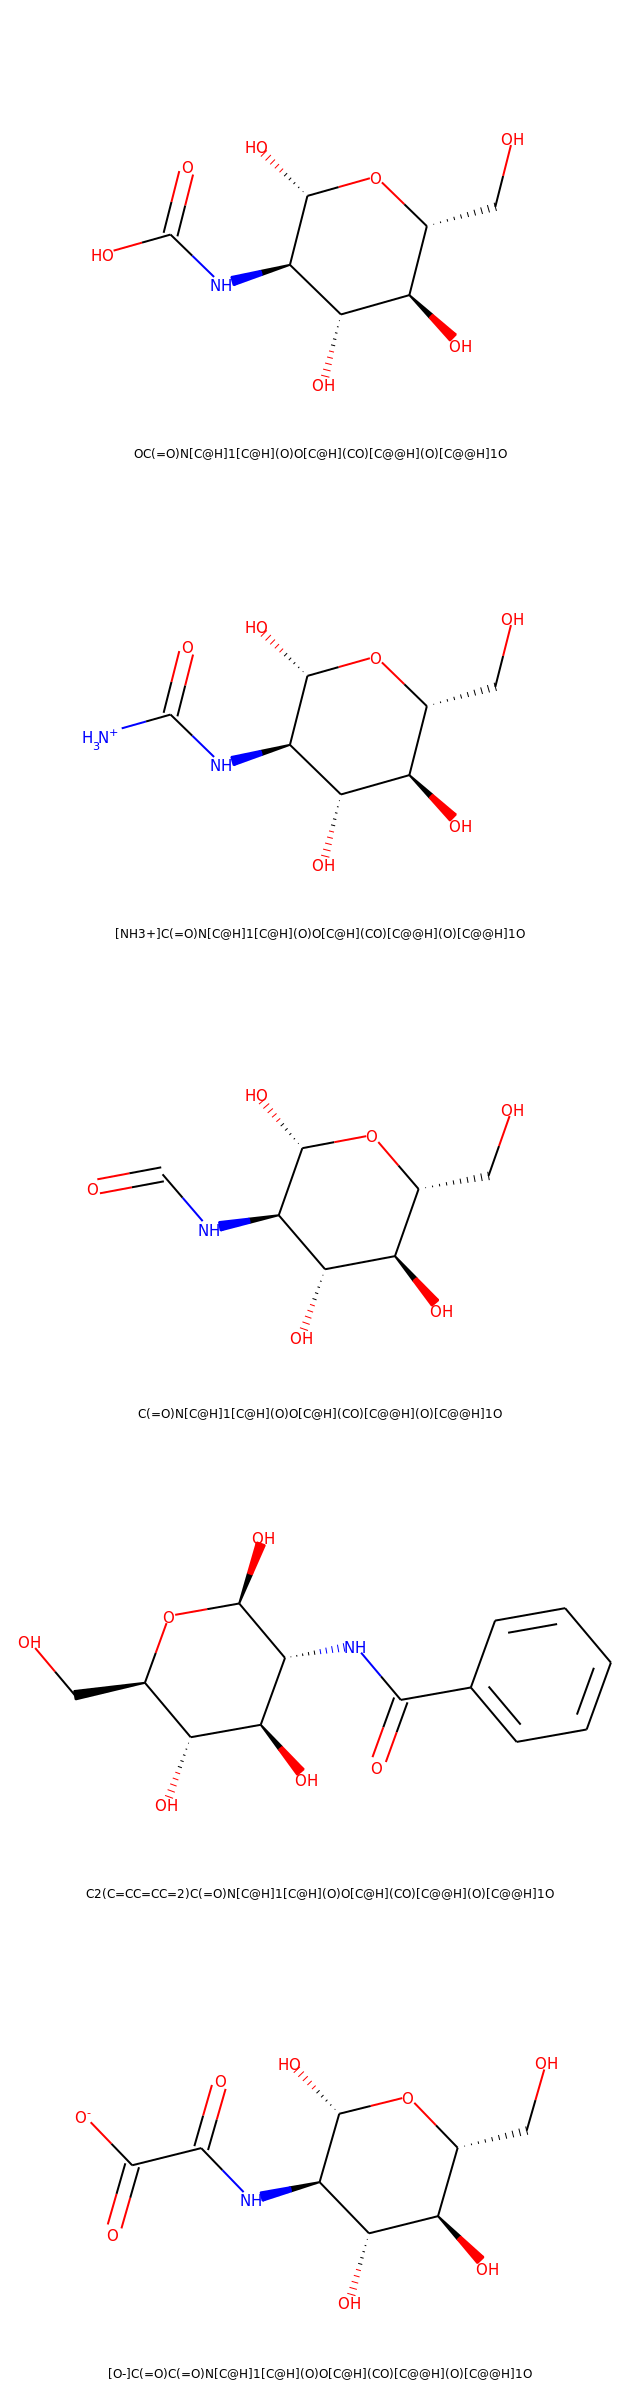

In [10]:
smiles = [
    'OC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',  # OH
    '[NH3+]C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',  # NH3+
    'C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',  # H
    'C2(C=CC=CC=2)C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',  # Ph - phenyl group
    '[O-]C(=O)C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O'  # COO-
]
mols2d, mols3d = [], []

for s in smiles:
    m2d = Chem.MolFromSmiles(s)
    m2d.Compute2DCoords()
    mols2d.append(m2d)
    m3d = Chem.AddHs(m2d)
    Chem.AllChem.EmbedMolecule(m3d)
    Chem.AllChem.MMFFOptimizeMolecule(m3d, maxIters=500, nonBondedThresh=100)
    mols3d.append(m3d)
    
    
Chem.Draw.MolsToGridImage(mols2d, molsPerRow=1, subImgSize=(640, 480), legends=smiles)

### Докинг

Создадим докинг-объект:

In [11]:
dock_obj = oddt.docking.AutodockVina.autodock_vina(
    protein=protein, size=(20, 20, 20), center=geom_center,
    executable='/home/leo/Software/vina/vina', autocleanup=True, num_modes=8,
    n_cpu=8
)

In [12]:
print(dock_obj.tmp_dir)

/tmp/autodock_vina_2tclqdca


In [13]:
print(' '.join(dock_obj.params))

--center_x 46.8601162045501 --center_y 32.48079069270644 --center_z 31.785813797351924 --size_x 20 --size_y 20 --size_z 20 --exhaustiveness 8 --num_modes 8 --energy_range 3


Здесь перечислены параметры докинга:

- **center(x, y, z)** - центр окна докинга, в данном случае совпадает с геометрическим центром исходного лиганда
- **size(x, y, z)** - размеры окна докинга, куб с соответствующими сторонами
- **exhaustiveness** - параметр времени, затраченного на поиск глобального минимума целевой функции
- **num_modes** - ограничение на количество генерируемых конформаций
- **energy_range** - максимальная энергетическая разница между лучшей и худшей из конформаций

Переведём молекулы из `rdkit`-формата в формат `oddt`:

In [14]:
mols = [oddt.toolkit.readstring('sdf', Chem.MolToMolBlock(m)) for m in mols3d]

Произведём докинг:

In [15]:
res = dock_obj.dock(ligands=mols, protein=protein)

Представим результаты в виде таблицы от лучшего заместителя к худшему (чем ниже значение Affinity, тем лучше контакт между белком и лигандом):

In [16]:
hbs, stack, phob = [], [], []

for r in res:
    hbs.append(oddt.interactions.hbonds(protein, r))
    stack.append(oddt.interactions.pi_stacking(protein, r))
    phob.append(oddt.interactions.hydrophobic_contacts(protein, r))

table = pd.DataFrame(
    data = {
        'Radical': np.repeat(np.array(['OH', 'NH3+', 'H', 'Phenyl', 'COO-']), 8),
        'Formula': [r.formula for r in res],
        'Vina Affinity': [r.data['vina_affinity'] for r in res],
        'RMSD UB': [r.data['vina_rmsd_ub'] for r in res],
        'H-bonds (total)': [len(h[0]) for h in hbs],
        'H-bonds (strict)': [sum(h[2]) for h in hbs],
        'Pi-stackings (total)': [len(st[0]) for st in stack],
        'Hydrophobic contacts(total)': [len(p[0]) for p in phob]
    }
)
table.sort_values('Vina Affinity', ascending=False)

,Radical,Formula,Vina Affinity,RMSD UB,H-bonds (total),H-bonds (strict),Pi-stackings (total),Hydrophobic contacts(total)
25,Phenyl,C13H17NO6,-6.3,2.970,10,9,0,9
32,COO-,C8H12NO8-,-6.3,0.000,9,8,0,0
24,Phenyl,C13H17NO6,-6.3,0.000,9,6,0,10
26,Phenyl,C13H17NO6,-6.2,5.049,5,5,3,11
27,Phenyl,C13H17NO6,-6.1,2.683,5,5,0,10
28,Phenyl,C13H17NO6,-6.0,7.948,5,4,0,2
29,Phenyl,C13H17NO6,-6.0,7.161,4,4,0,4
33,COO-,C8H12NO8-,-6.0,5.563,9,8,0,0
30,Phenyl,C13H17NO6,-5.9,6.211,2,2,4,9
31,Phenyl,C13H17NO6,-5.9,3.209,5,3,1,16


Запишем файлы для визуализации:

In [17]:
for i, r in enumerate(res):
    r.write(filename=f'{i}.pdb', format='pdb', overwrite=True)

### Визуализация

Напишем функцию для визуализации лиганда с белком и отобразим пару лучших результатов:

In [18]:
def binding_viewer(ligand):
    v = nv.show_structure_file('protein.pdb')
    v.add_component(ligand)
    v._remote_call('setSize', target='Widget', args=['500px', '500px'])
    v.representations = [
            {"type": "cartoon", "params": {"sele": "protein", "color": "residueindex"}},
            {"type": "ball+stick", "params": {"sele": "ligand"}}
        ]
    return v

oh = binding_viewer('0.pdb')
nh3 = binding_viewer('8.pdb')
h = binding_viewer('16.pdb')
ph = binding_viewer('24.pdb')
coo = binding_viewer('32.pdb')

По порядку: **OH, NH3+, H, Ph, COO-**:

In [21]:
HBox((oh, nh3))

In [22]:
HBox((h, ph))

In [24]:
coo

NGLWidget()

Перезагрузка виджета для отображения в HTML:

In [ ]:
# nv.write_html('view.html', views=[ph])

In [ ]:
# ipd.HTML('view.html')